# Bayesian Optimization

In this notebook, I first build a class that implements a Bayesian Optimization algorithm. Next, I apply the algorithm to a few toy functions to demonstrate and visualize the method.

Bayesian Optimization is a derivative-free method that can optimize non-convex functions. All that's required is the ability to evaluate the objective function. Very cool stuff. As a consequence, you'll notice a few things:
- Derivative/gradient computations exist nowhere in this notebook
- The toy functions have local minima/maxima

For the above reasons, Bayesian optimization is a popular method for optimizing functions that either contain several local minima or are not amenable to gradient computations. Tuning hyperparameters for deep neural networks is one such area that meets these conditions and where Bayesian optimization is common.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('darkgrid')
seaborn.set_context("talk")
%matplotlib inline

In [25]:
class BayesianOpt():
    
    def __init__(self, function, bounds, theta, n_initial_samples=0):
        # TO-DO
        # Check that bounds is the correct datatype: a list of tuples
        
        # TO-DO
        # Check that dimensions implied by <bounds> is the same as that from <function>

        self.function = function
        self.bounds = bounds
        self.theta = theta
        
    def initial_sample(self, n):
        '''
        Uniformly sample n points from the input space.
        This is used to initialize the algorithm.
        '''
        # To-do
        # Remove this function; place code inside __init__(). Make n_initial_samples an init argument
        
        self.X = self.sample_domain(n)
        self.f = np.array([self.function(x) for x in self.X]) # likely impractical for non-toy problems

    def sample_domain(self, n):
        '''
        Uniformly sample points from the input space.
        
        Arguments
        ---------
        n : int
            How many points to sample
        '''
        return np.array([np.random.uniform(b[0], b[1], n) for b in self.bounds]).T
    
    def step(self, n):
        '''
        Sample a new point. This point should maximize EI.
        '''
        z = self.sample_domain(n)
        posterior = [self.get_posterior(z_i) for z_i in z]
        mu_list = np.array([p[0] for p in posterior])
        var_list = np.array([p[1] for p in posterior])
        EI_list = np.array([self.get_EI(z_i) for z_i in z])
        
        next_sample = z[np.argmax(EI_list)]
        
        
        # PLOT -- Note: this visualization only works for 1-D functions
        # --------
        
        plt.figure(figsize=(20,12))
        ordering_index = np.argsort(z[:,0])
        plt.subplot(2,1,1)
        
        # Plot true function
        plt.plot(z[ordering_index], 
                 np.array([self.function(z_i) for z_i in z])[ordering_index],
                 c='orange', label='True Function')

        # Plot samples
        plt.scatter(self.X, self.f, c='orange', s=150)

        # Plot predicted function
        plt.plot(z[ordering_index], 
                 mu_list[ordering_index], 
                 c='dodgerblue', label='Predicted')
        l = mu_list - 1.96 * np.sqrt(var_list)
        u = mu_list + 1.96 * np.sqrt(var_list)
        plt.fill_between(z[ordering_index].squeeze(), 
                         l[ordering_index], 
                         u[ordering_index],
                         color='dodgerblue', alpha=0.2, label='uncertainty bounds')
        
        # Plot maximum value of samples
        plt.axhline(y=self.f.max(), c='k', linewidth=2, label='max sample')

        # Plot point that maximizes EI
        plt.axvline(x=next_sample, c='k', linewidth=2, linestyle='--', label='next sample location')

        
        plt.title('Predicted + True Function')
        plt.legend()
                
        # Plot expected improvement
        plt.subplot(2,1,2)
        plt.plot(z[ordering_index], EI_list[ordering_index], c='green', label='EI')
        plt.title('Expected Improvement')
        
        plt.show()

        
        # Sample a new point and add it to set of collected samples
        self.X = np.append(self.X,
                           next_sample.reshape((1,self.X.shape[1])),
                           axis=0)
        self.f = np.append(self.f, self.function(next_sample)) # inefficient but small data                
        
        
    def kernel(self, x_i, x_j):
        return np.exp(-0.5 * np.square(x_i - x_j).sum() / (self.theta**2))
        
    def get_posterior(self, x_t):
        K = np.array([[self.kernel(x_i, x_j) for x_j in self.X] for x_i in self.X])
        # TO-DO? multiply K by self.f.var() ?
        k = np.array([self.kernel(x_t, x_j) for x_j in self.X])
        mean = self.f.mean() + k.dot(np.linalg.solve(K, self.f - self.f.mean()))
        var = self.kernel(x_t, x_t) - k.dot(np.linalg.solve(K,k))
        var *= self.f.var()  # <------------------- double check the math
        return mean, var + 1e-5  # add small value for numerical stability
    
    def EI_calculation(self, mu, sigma):
        # TO-DO
        # Incorporate offset parameter that controls exploration/exploitation
        if sigma > 1e-5:
            best_yet = self.f.max()
            Z = (mu - best_yet)/sigma
            return (mu - best_yet)*norm.cdf(Z) + sigma*norm.pdf(Z)
        else:
            return 0

    def get_EI(self, x_t):
        mu, var = self.get_posterior(x_t)
        #var *= self.f.var()
        sigma = np.sqrt(var)
        return self.EI_calculation(mu, sigma)




# Toy function 1

In [26]:
def test_function_1(x):
    x = x[0] # flatten np array
    return 20*np.sin(2*x) - 3*x**2 + x

bounds_1 = [(-5,5)]


**************************************************************************************************************
STEP 0


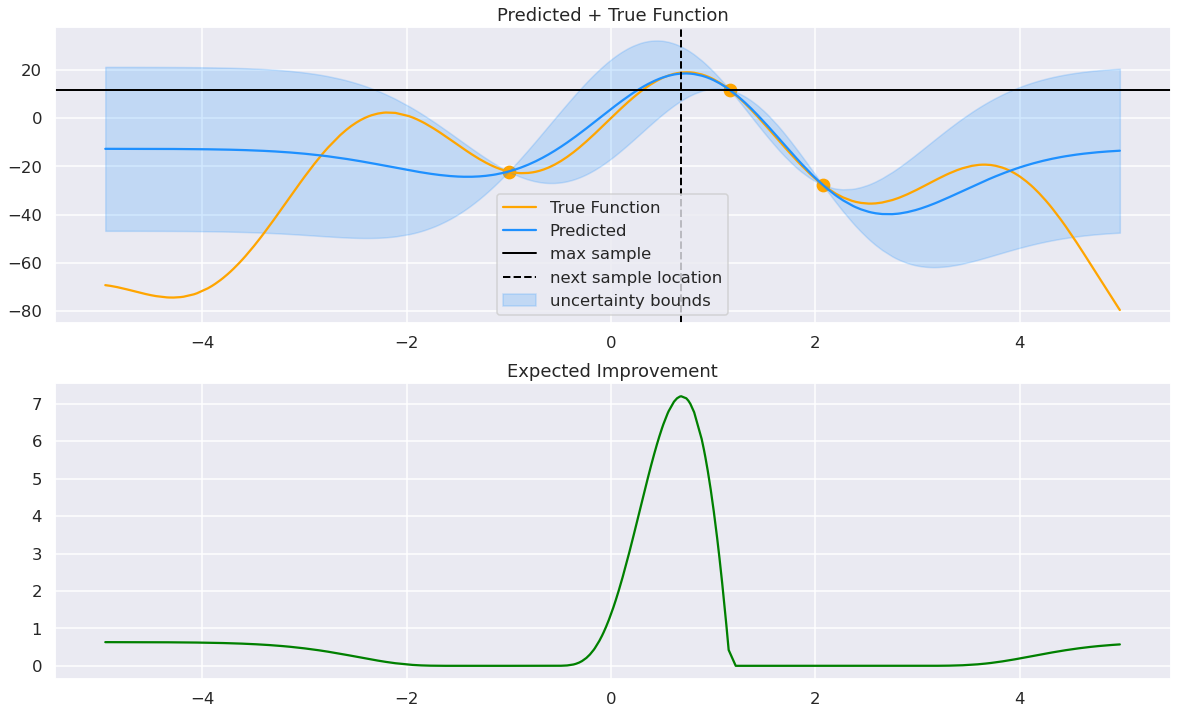

**************************************************************************************************************
STEP 1


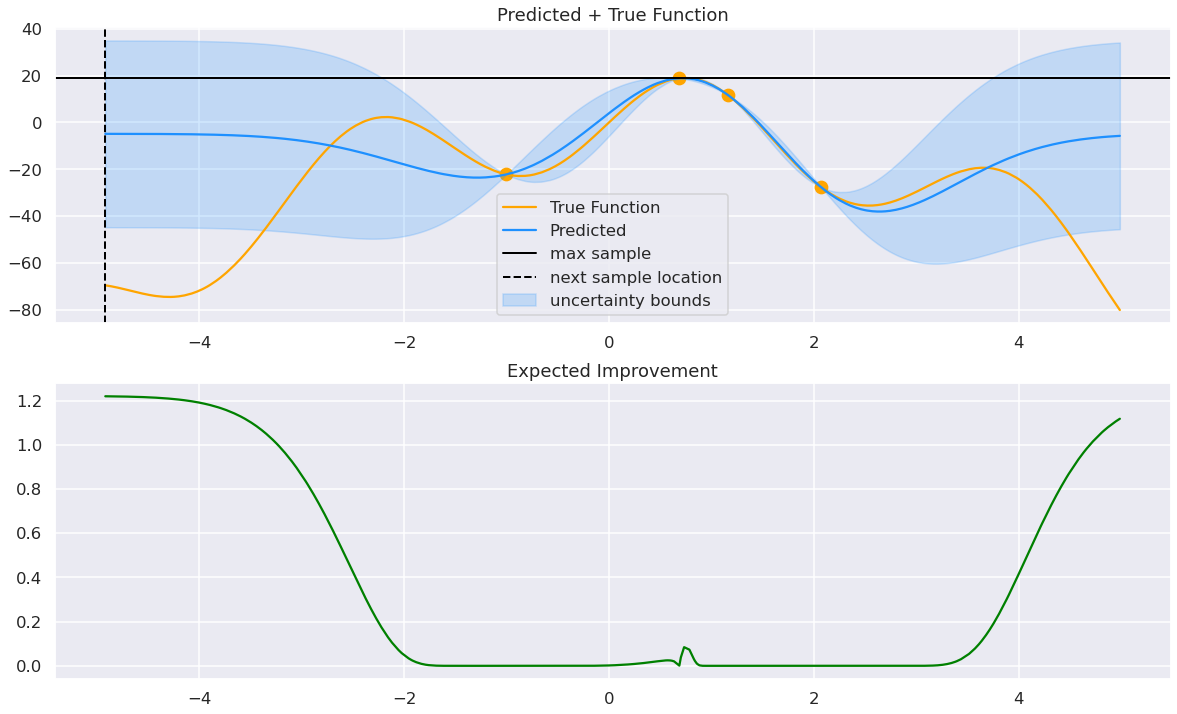

**************************************************************************************************************
STEP 2


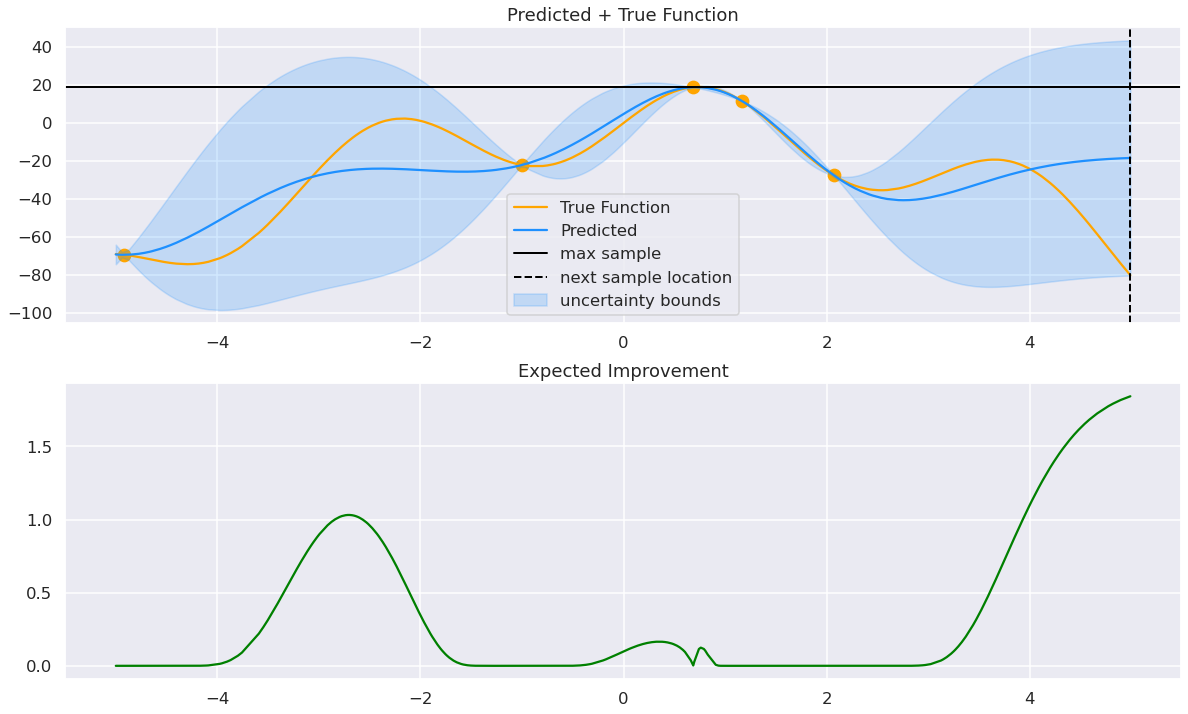

**************************************************************************************************************
STEP 3


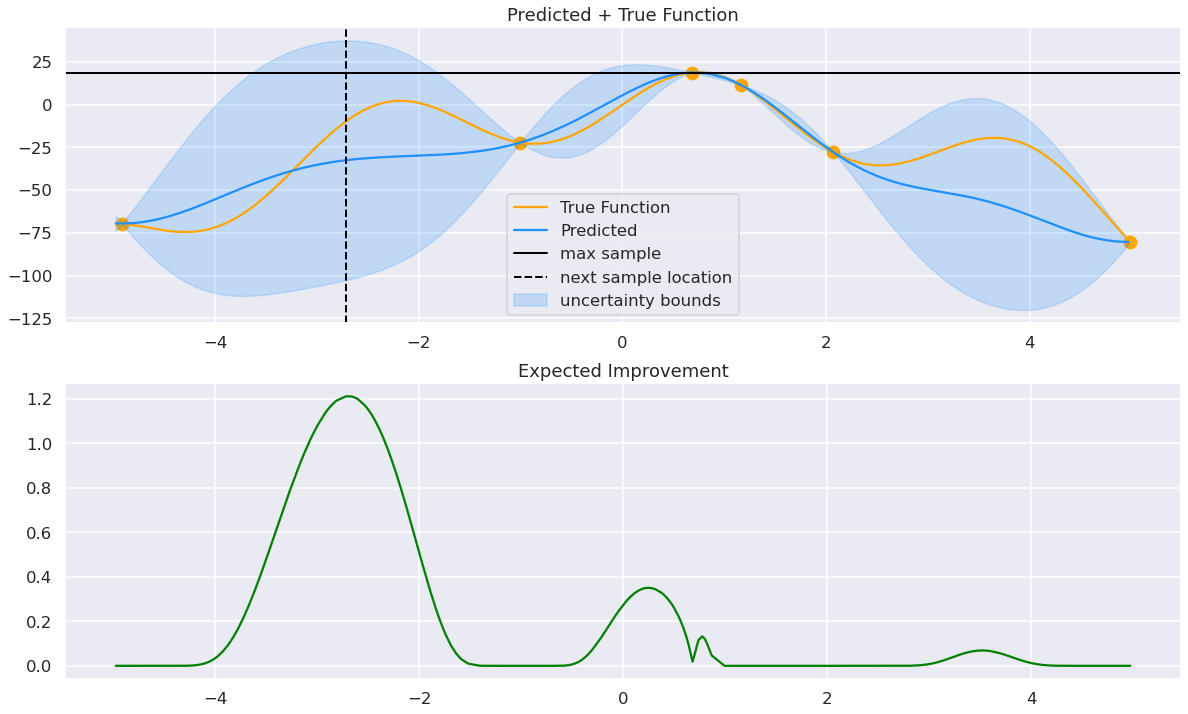

**************************************************************************************************************
STEP 4


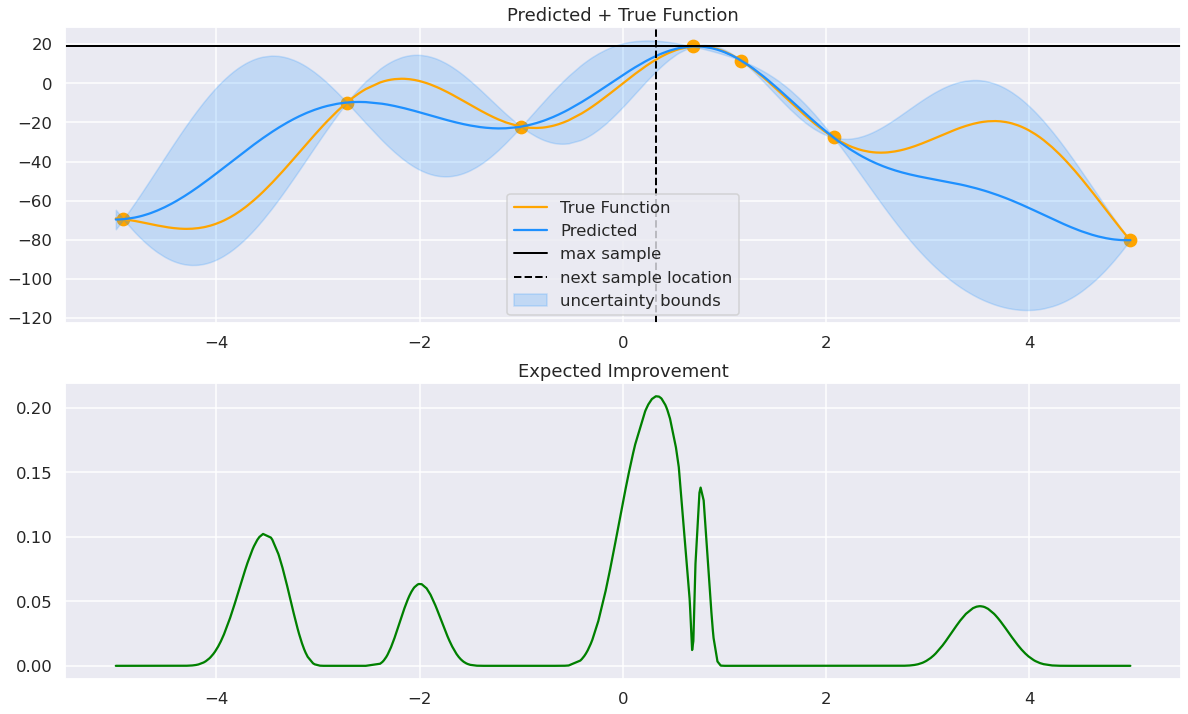

**************************************************************************************************************
STEP 5


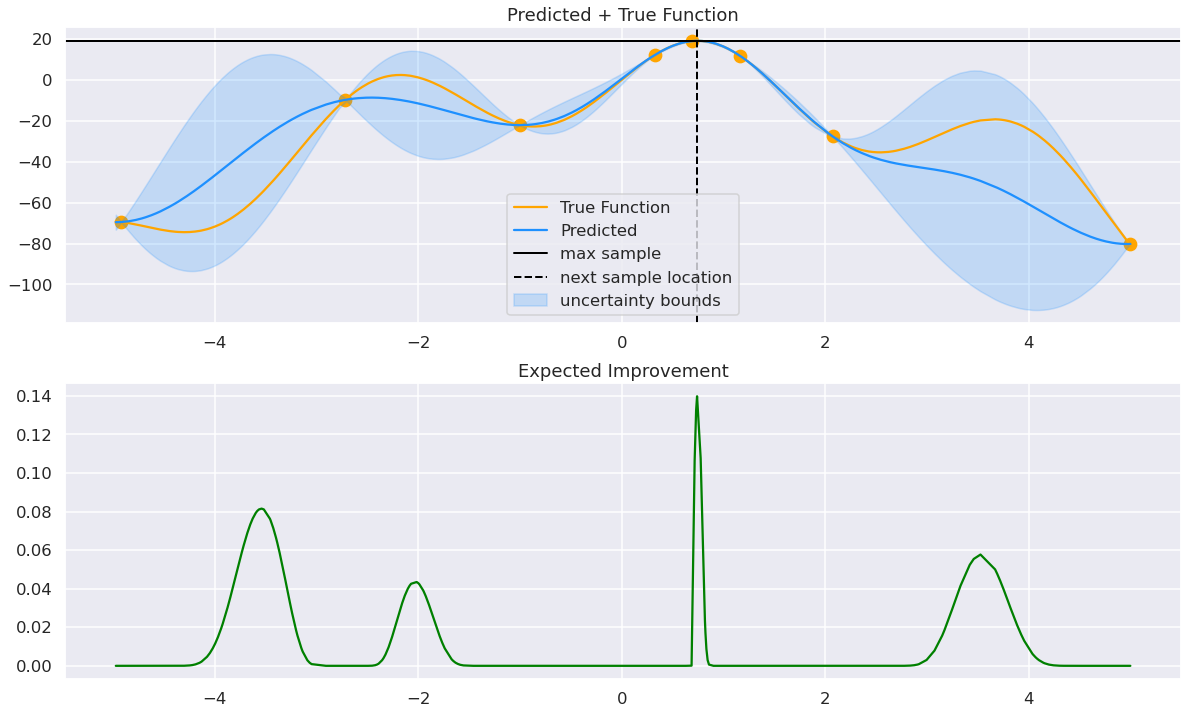

**************************************************************************************************************
STEP 6


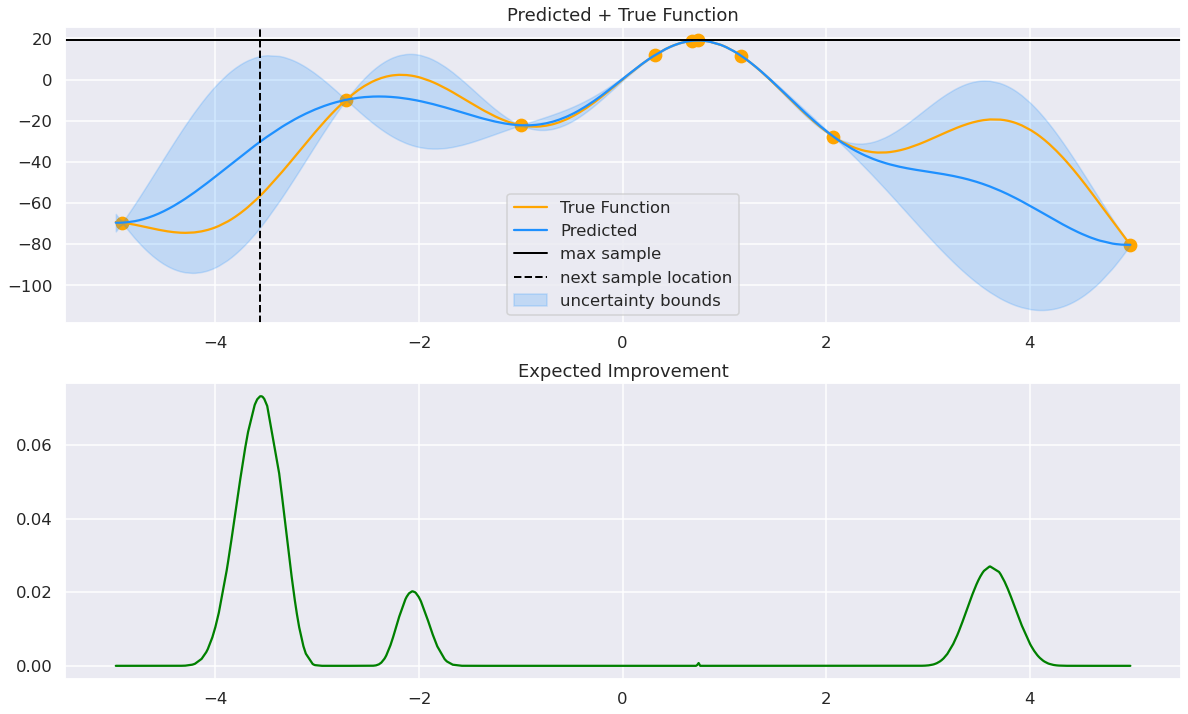

In [27]:
# Parameters
n_initial_samples = 3
n_addtitional_samples = 7
theta = 1

#-----------------------------------------------------------------------------

BO = BayesianOpt(function=test_function_1, bounds=bounds_1, theta=theta)
BO.initial_sample(n_initial_samples)

# Sample additional points
for i in range(n_addtitional_samples):
    print('*'*110 + '\n' + 'STEP {}'.format(i))
    BO.step(n=500)
    

# Toy function 2

In [28]:
def test_function_2(x):
    '''
    Input x: np array of shape (k,)
    '''
    x = x[0]
    return - 1e-5 * (x + 80) * (x + 30) * (x - 20) * (x - 95) + 1000

bounds_2 = [(-100,100)]


**************************************************************************************************************
STEP 0


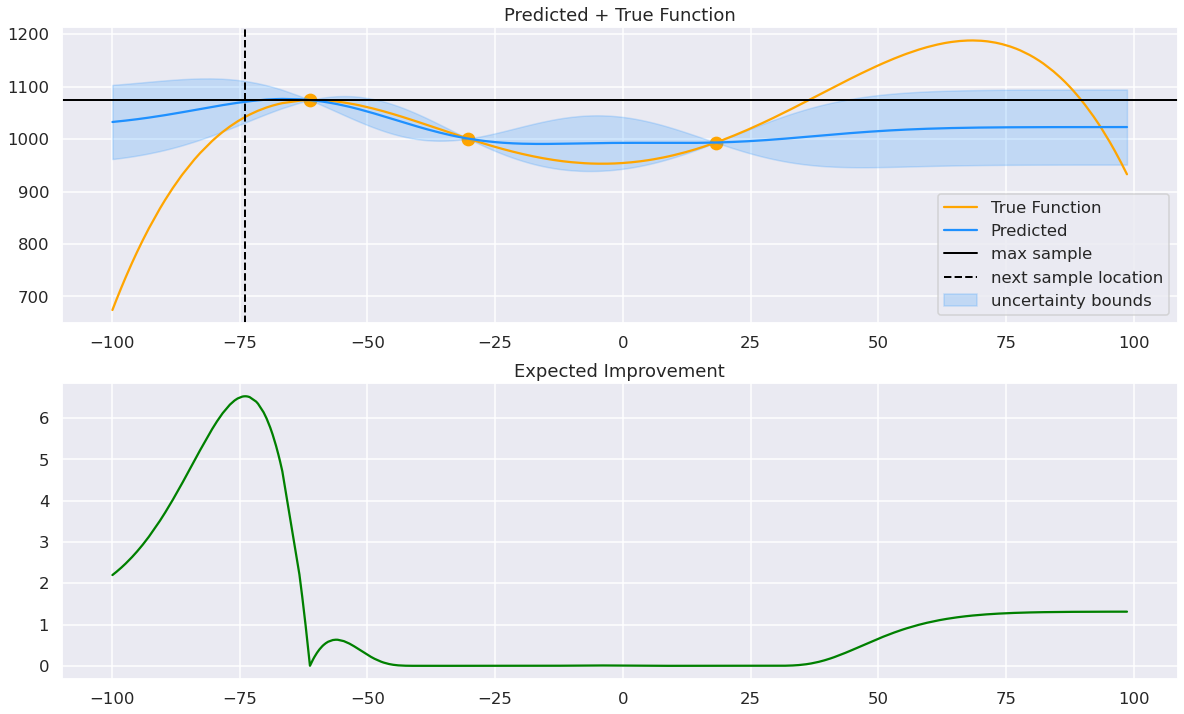

**************************************************************************************************************
STEP 1


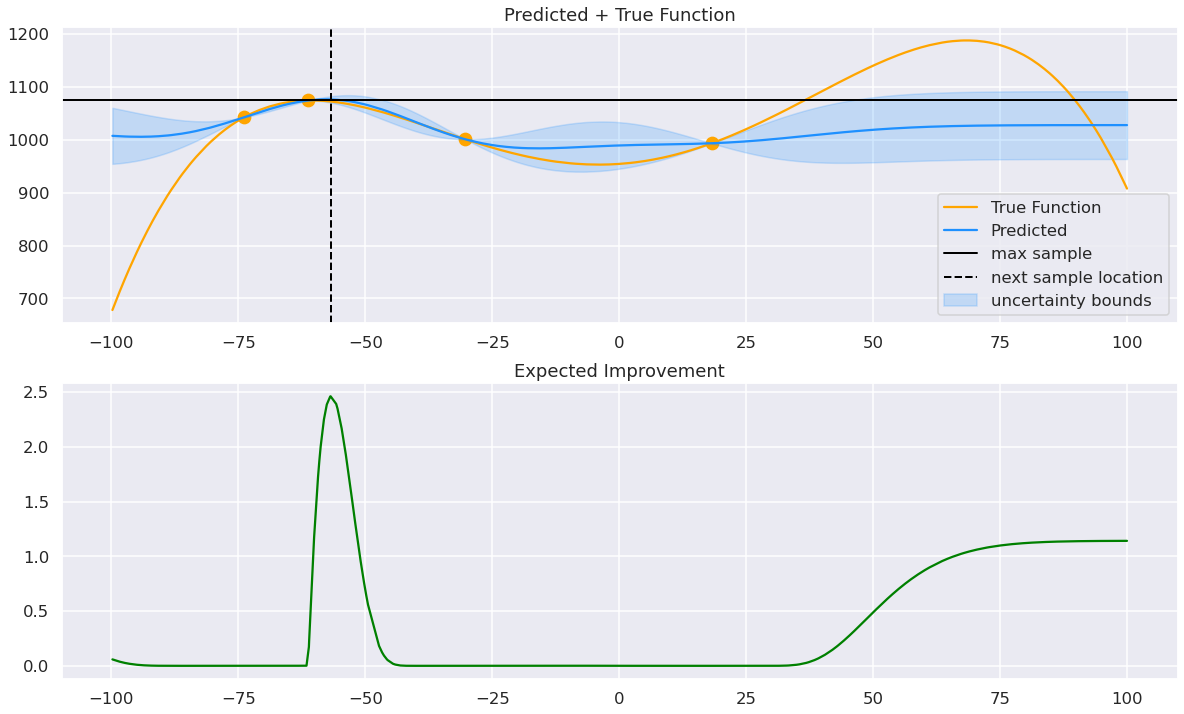

**************************************************************************************************************
STEP 2


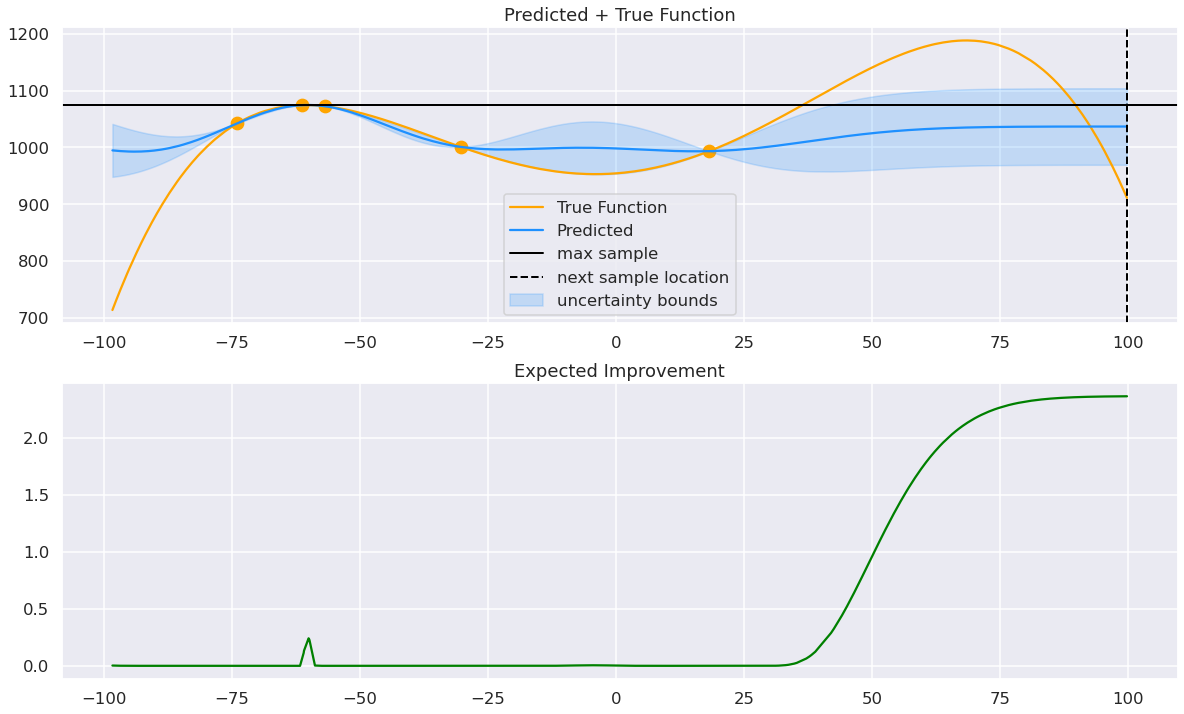

**************************************************************************************************************
STEP 3


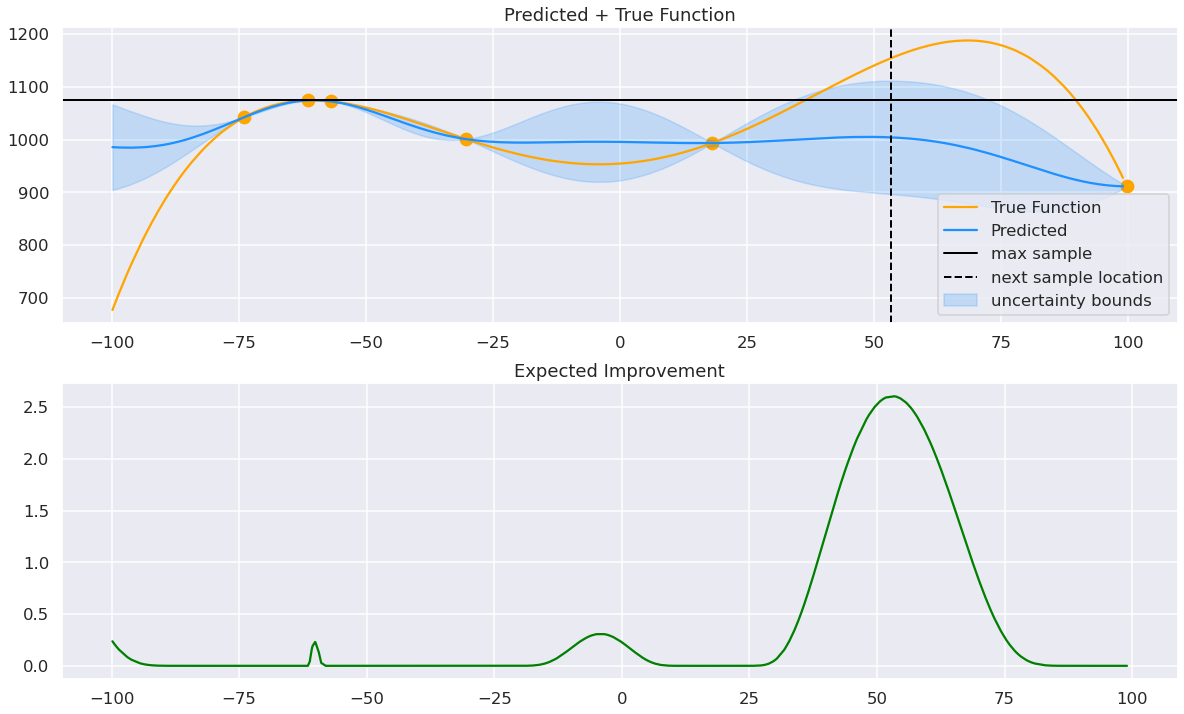

**************************************************************************************************************
STEP 4


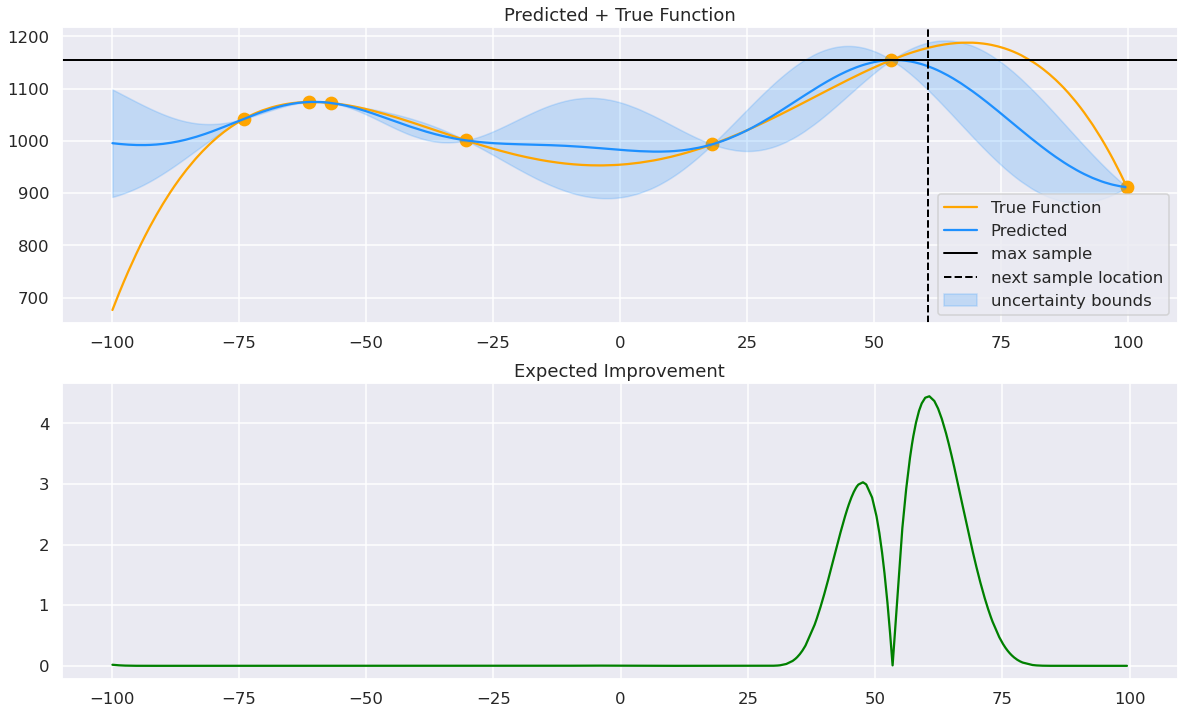

**************************************************************************************************************
STEP 5


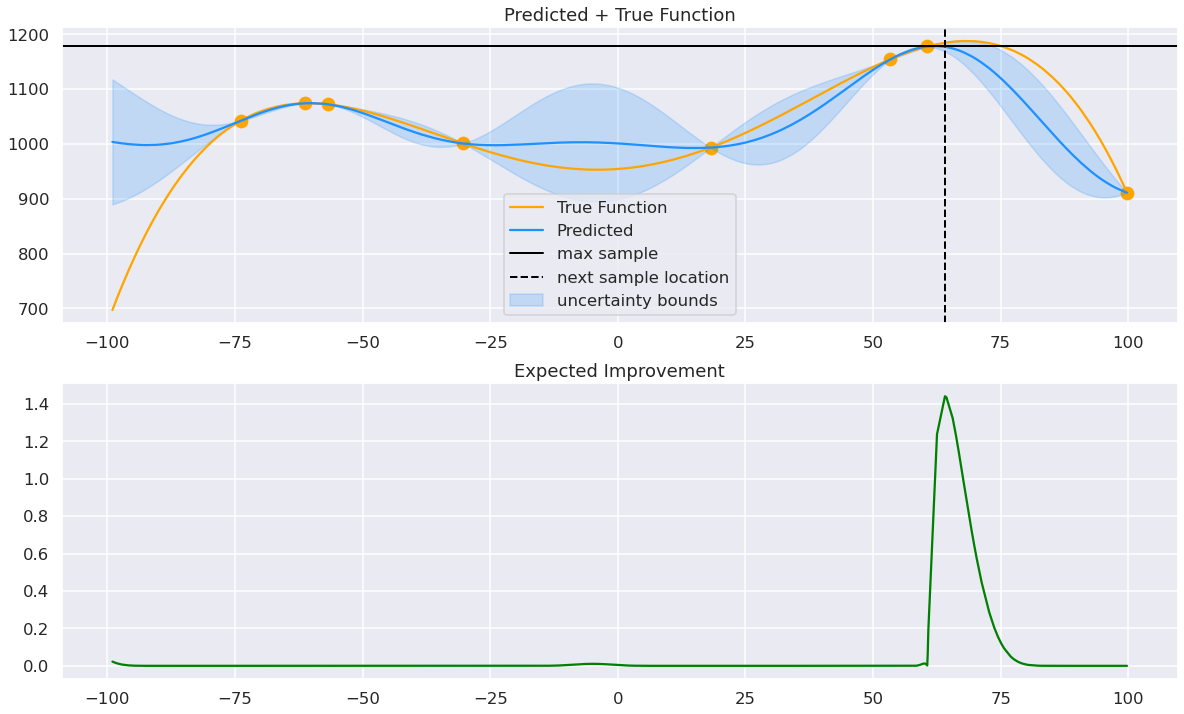

**************************************************************************************************************
STEP 6


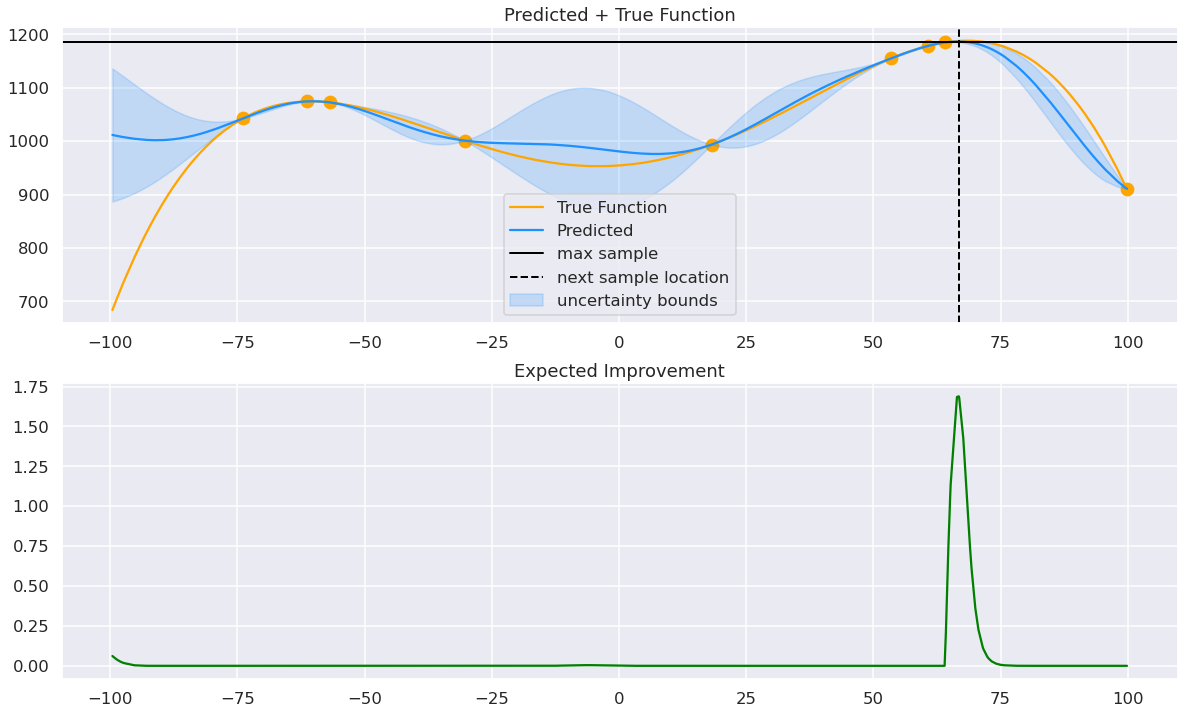

In [30]:
# Parameters
n_initial_samples = 3
n_addtitional_samples = 7
theta = 20

#-----------------------------------------------------------------------------

BO = BayesianOpt(function=test_function_2, bounds=bounds_2, theta=theta)
BO.initial_sample(n_initial_samples)

# Sample additional points
for i in range(n_addtitional_samples):
    print('*'*110 + '\n' + 'STEP {}'.format(i))
    BO.step(n=500)
    